In [2]:
import pandas                             as      pd
import numpy                              as      np
import matplotlib.pyplot                  as      plt
import seaborn                            as      sns
from   IPython.display                    import  display
from   pylab                              import  rcParams 
from   datetime                           import  datetime, timedelta
from statsmodels.tsa.stattools            import  adfuller
from statsmodels.tsa.stattools            import  pacf
from statsmodels.tsa.stattools            import  acf
from statsmodels.graphics.tsaplots        import  plot_pacf
from statsmodels.graphics.tsaplots        import  plot_acf
from statsmodels.graphics.gofplots        import  qqplot
from statsmodels.tsa.seasonal             import  seasonal_decompose
from statsmodels.tsa.arima_model          import  ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax   import  SARIMAX
from arch import arch_model
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [3]:
def MAE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred)))

def MAPE(y_true,y_pred):
    return np.mean((np.abs(y_true - y_pred))/(y_true))*100

In [4]:
df = pd.read_csv('Energy_consumption_India_2.csv')
df.head()

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9


In [5]:
df.tail()

,States,Regions,latitude,longitude,Dates,Usage
16594,Manipur,NER,24.799971,93.950017,05/12/2020 00:00:00,2.5
16595,Meghalaya,NER,25.570492,91.880014,05/12/2020 00:00:00,5.8
16596,Mizoram,NER,23.710399,92.720015,05/12/2020 00:00:00,1.6
16597,Nagaland,NER,25.666998,94.116570,05/12/2020 00:00:00,2.1
16598,Tripura,NER,23.835404,91.279999,05/12/2020 00:00:00,3.3


In [6]:
df.shape

(16599, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16599 entries, 0 to 16598
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   States     16599 non-null  object 
 1   Regions    16599 non-null  object 
 2   latitude   16599 non-null  float64
 3   longitude  16599 non-null  float64
 4   Dates      16599 non-null  object 
 5   Usage      16599 non-null  float64
dtypes: float64(3), object(3)
memory usage: 778.2+ KB


In [8]:
df.isnull().sum()

States       0
Regions      0
latitude     0
longitude    0
Dates        0
Usage        0
dtype: int64

In [9]:
df['date'] = pd.to_datetime(df['Dates'])

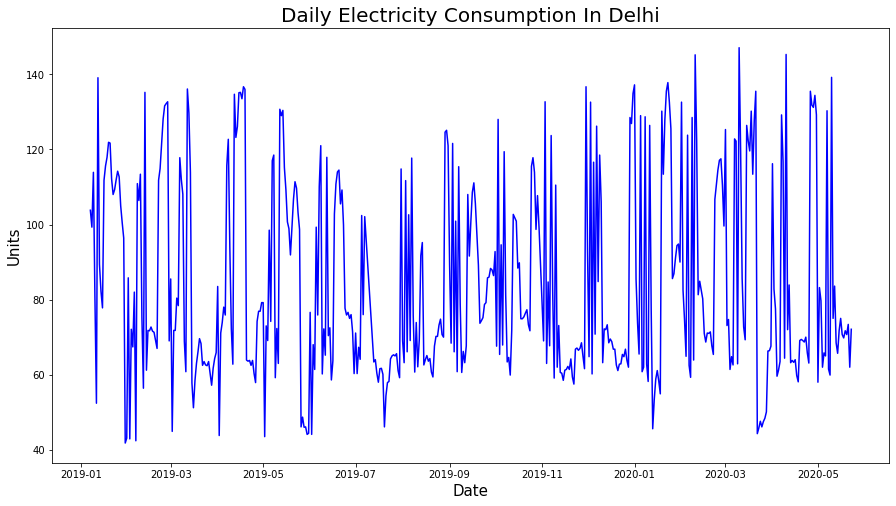

In [10]:
df_del = df[df['States'] == 'Delhi']
df_del_grp = df_del.groupby('date').agg({'Usage':'sum'})
plt.plot(df_del_grp,color='blue',linewidth=1.5)
plt.title('Daily Electricity Consumption In Delhi',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [11]:
df_del_grp.head()

,Usage
date,
2019-01-07,103.8
2019-01-08,99.3
2019-01-09,113.9
2019-01-10,80.7
2019-01-11,52.4


In [12]:
df_del_grp.tail()

,Usage
date,
2020-05-19,71.7
2020-05-20,70.7
2020-05-21,73.4
2020-05-22,62.0
2020-05-23,72.1


In [13]:
len(df_del_grp)

498

In [14]:
time = pd.date_range(start='1/7/2019',periods=498,freq='D')

In [15]:
df_del_grp.set_index(time,inplace=True)

In [16]:
df_del_grp

,Usage
2019-01-07,103.8
2019-01-08,99.3
2019-01-09,113.9
2019-01-10,80.7
2019-01-11,52.4
...,...
2020-05-14,71.7
2020-05-15,70.7
2020-05-16,73.4
2020-05-17,62.0


In [17]:
df = df_del_grp.copy()

In [18]:
plt.rcParams['figure.figsize'] = [15,8]

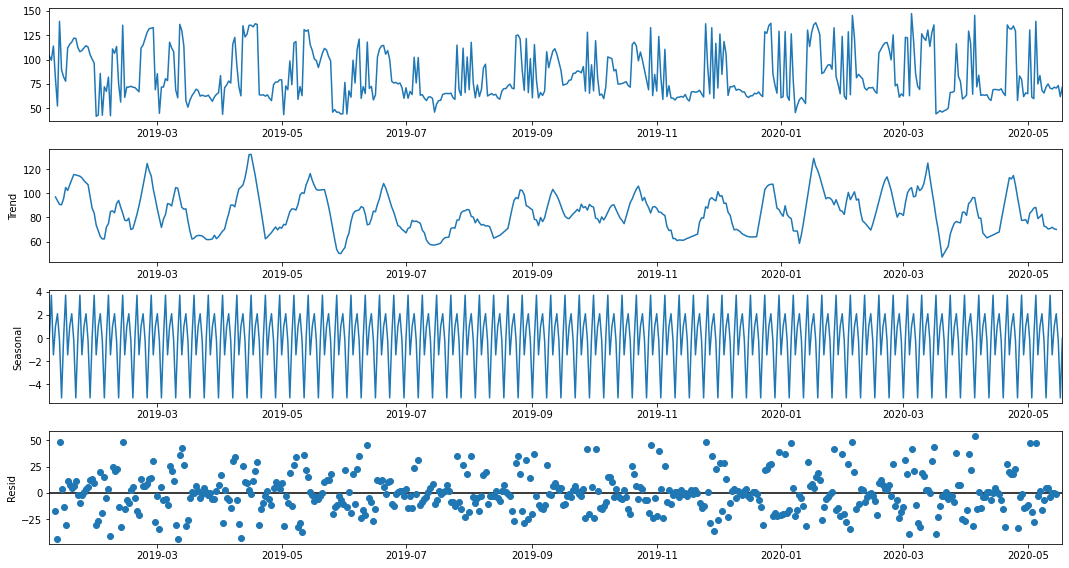

In [19]:
decomposition_model = seasonal_decompose(df,model='additive')
decomposition_model.plot();

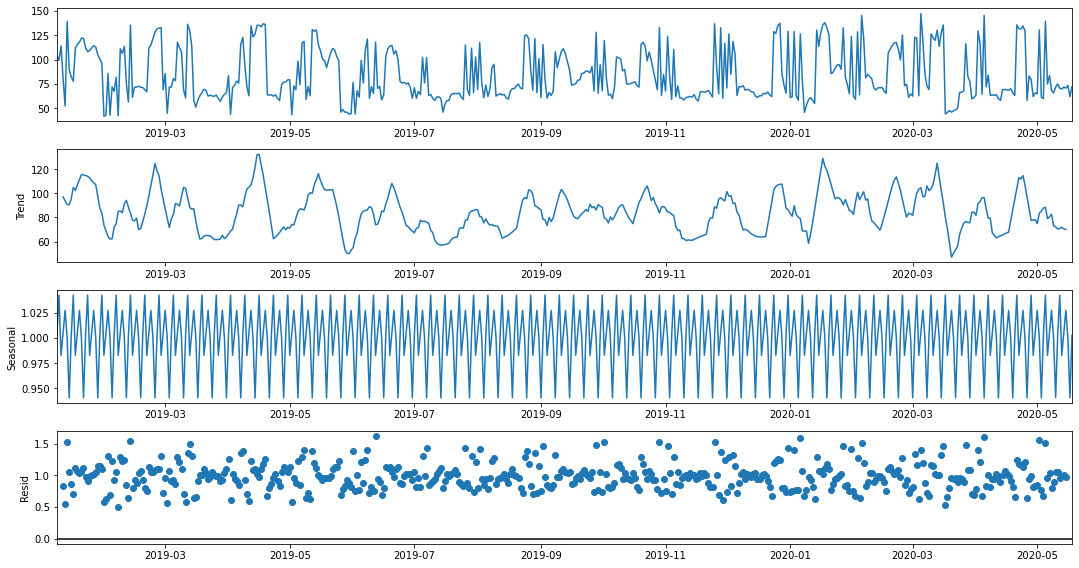

In [20]:
decomposition_model = seasonal_decompose(df,model='multiplicative')
decomposition_model.plot();

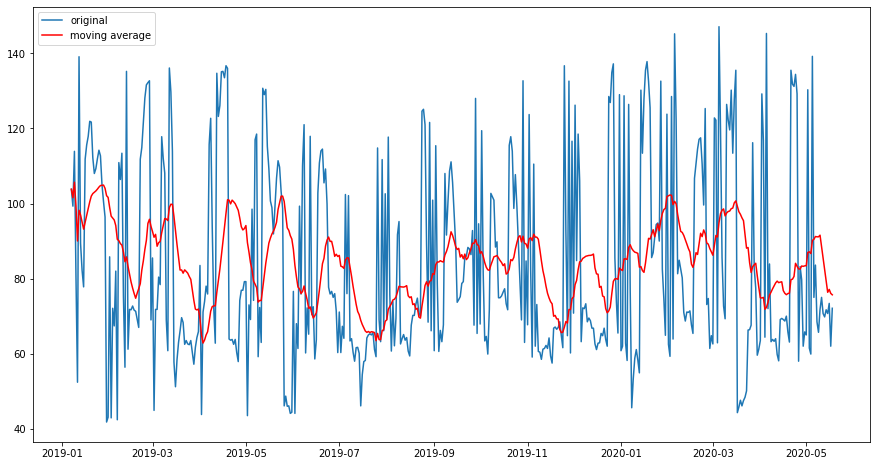

In [21]:
plt.plot(df,label='original')
plt.plot(df.rolling(20,min_periods=0).mean(),label='moving average',color='r')
plt.legend(loc='best')
plt.show()

In [22]:
# Model building - Exponential Smoothing Techniques

In [23]:
train_end = datetime(2020,3,31)
test_end = datetime(2020,5,19)

In [24]:
train = df[:train_end]
test = df[train_end + timedelta(days=1):test_end]

In [25]:
train.tail()

,Usage
2020-03-27,116.2
2020-03-28,82.8
2020-03-29,77.5
2020-03-30,59.6
2020-03-31,61.2


In [26]:
test.head()

,Usage
2020-04-01,63.5
2020-04-02,129.2
2020-04-03,116.7
2020-04-04,64.4
2020-04-05,145.3


In [27]:
len(train)

450

In [28]:
len(test)

48

##### Simple Exponential Smoothing

In [29]:
SES = SimpleExpSmoothing(train,initialization_method='estimated')
SES_model = SES.fit(optimized=True)
SES_model.summary()

Dep. Variable:,Usage,No. Observations:,450
Model:,SimpleExpSmoothing,SSE,257761.466
Optimized:,True,AIC,2861.744
Trend:,None,BIC,2869.963
Seasonal:,None,AICC,2861.834
Seasonal Periods:,None,Date:,"Tue, 05 Apr 2022"
Box-Cox:,False,Time:,01:53:03
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4230037,alpha,True
initial_level,100.31552,l.0,True


In [30]:
SES_predict = SES_model.forecast(len(test))

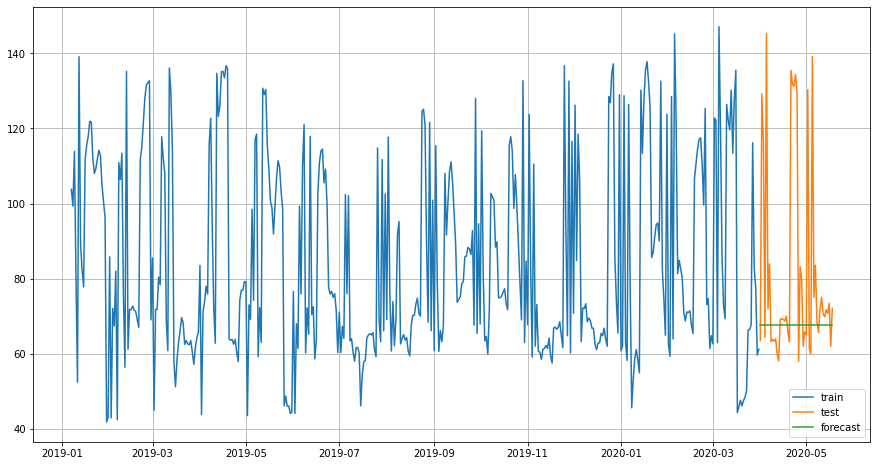

In [31]:
plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(SES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [32]:
print("MAE:",MAE(test['Usage'],SES_predict))
print("MAPE:",MAPE(test['Usage'],SES_predict))

MAE: 17.709058337334195
MAPE: 16.24420463873181


##### Double Exponential Smoothing

In [33]:
DES = Holt(train,exponential=False,initialization_method='estimated')
DES_model = DES.fit(optimized=True)
DES_model.summary()

Dep. Variable:,Usage,No. Observations:,450
Model:,Holt,SSE,257823.121
Optimized:,True,AIC,2865.852
Trend:,Additive,BIC,2882.289
Seasonal:,None,AICC,2866.041
Seasonal Periods:,None,Date:,"Tue, 05 Apr 2022"
Box-Cox:,False,Time:,01:54:06
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4249917,alpha,True
smoothing_trend,0.0002439,beta,True


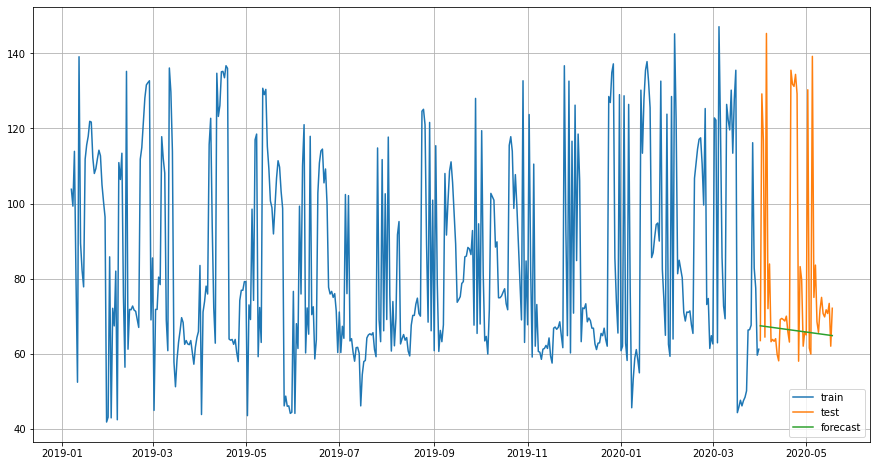

In [34]:
DES_predict = DES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(DES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [35]:
print("MAE:",MAE(test['Usage'],DES_predict))
print("MAPE:",MAPE(test['Usage'],DES_predict))

MAE: 18.24421909205825
MAPE: 16.718723321592837


##### Triple Exponential Smoothing

In [36]:
TES = ExponentialSmoothing(train,trend='multiplicative',seasonal='additive',initialization_method='estimated')
TES_model = TES.fit(smoothing_level=0.3004441,
    smoothing_trend=0.0200759,
    smoothing_seasonal=0.0555906)
TES_model.summary()

Dep. Variable:,Usage,No. Observations:,450
Model:,ExponentialSmoothing,SSE,286632.377
Optimized:,True,AIC,2927.519
Trend:,Multiplicative,BIC,2972.720
Seasonal:,Additive,AICC,2928.354
Seasonal Periods:,7,Date:,"Tue, 05 Apr 2022"
Box-Cox:,False,Time:,01:54:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3004441,alpha,False
smoothing_trend,0.0200759,beta,False


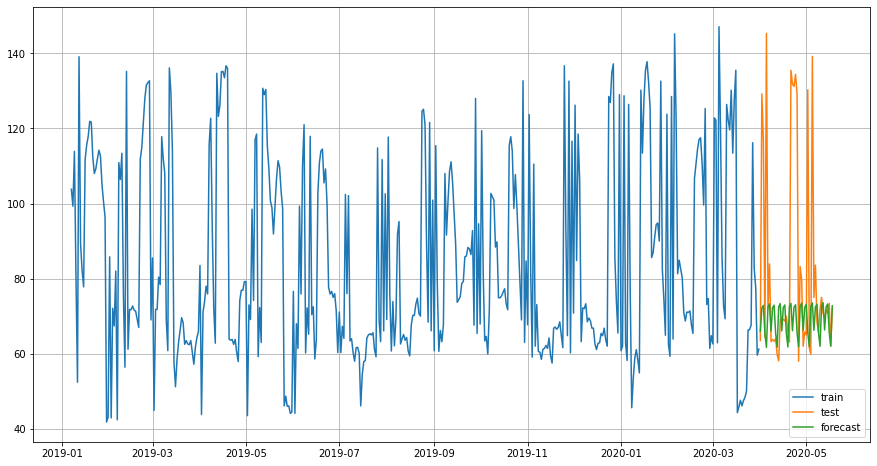

In [37]:
TES_predict = TES_model.forecast(len(test))

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(TES_predict,label='forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

In [38]:
print("MAE:",MAE(test['Usage'],TES_predict))
print("MAPE:",MAPE(test['Usage'],TES_predict))

MAE: 17.087562372125234
MAPE: 15.725269751738837


##### ACF and PACF plots

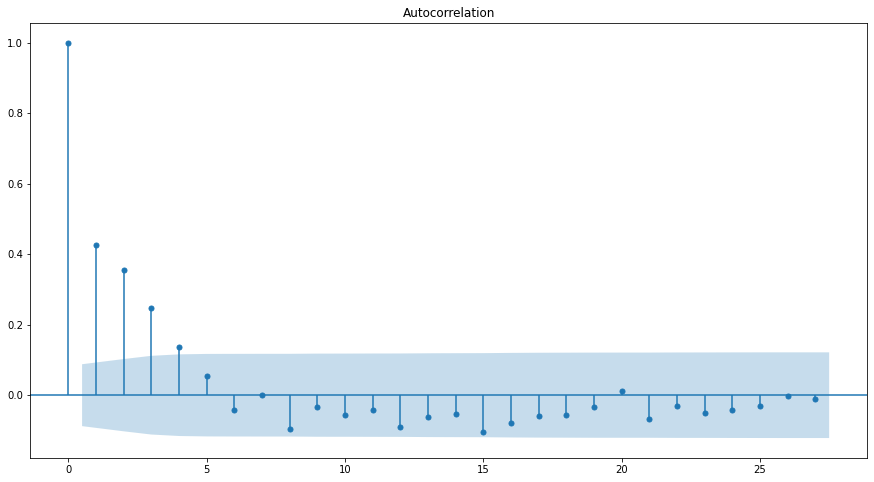

In [39]:
plot_acf(df)
plt.show()

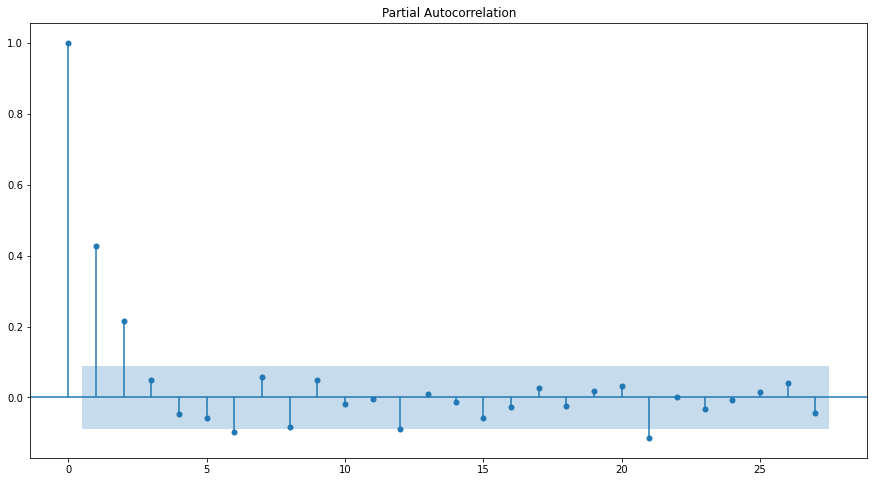

In [199]:
plot_pacf(df)
plt.show()

##### DickyFuller test

In [40]:
observations = df.values
df_results = adfuller(observations)
df_results

(-7.550445166495395,
 3.1993244572133535e-11,
 7,
 490,
 {'1%': -3.4437660979098843,
  '5%': -2.8674565460819896,
  '10%': -2.569921291128696},
 4368.338915518657)

In [201]:
##### stationary series -- proceed with ARMA & SARIMA model

##### ARMA Model

In [84]:
model=ARMA(train,(2,2))
model_fit=model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Usage   No. Observations:                  450
Model:                     ARMA(2, 2)   Log Likelihood               -2042.062
Method:                       css-mle   S.D. of innovations             22.614
Date:                Tue, 05 Apr 2022   AIC                           4096.124
Time:                        02:02:23   BIC                           4120.780
Sample:                    01-07-2019   HQIC                          4105.842
                         - 03-31-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          84.4627      2.214     38.150      0.000      80.123      88.802
ar.L1.Usage     1.3612      0.244      5.582      0.000       0.883       1.839
ar.L2.Usage    -0.5444      0.180     -3.033    

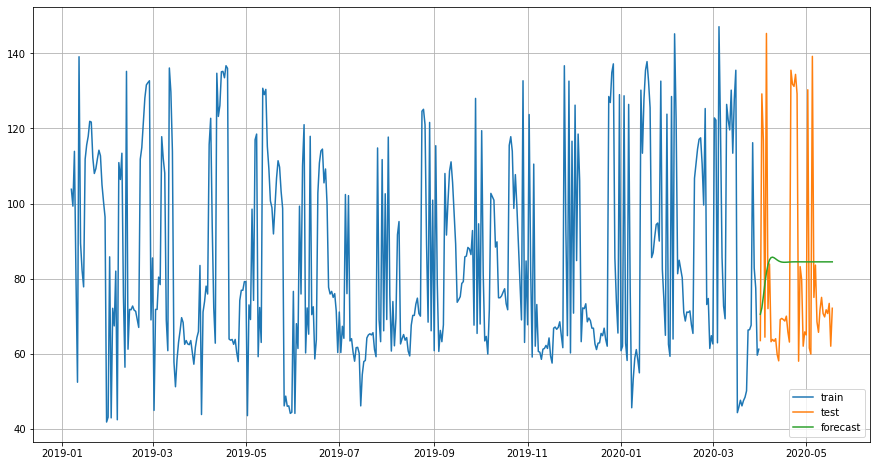

In [85]:
forecasted_values_arma = pd.Series(model_fit.forecast(len(test))[0],index=test.index)

# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecasted_values_arma,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [82]:
print("MAE:",MAE(test['Usage'],forecasted_values_arma))
print("MAPE:",MAPE(test['Usage'],forecasted_values_arma))

MAE: 22.92557400763287
MAPE: 26.98168701875941


In [45]:
from warnings import filterwarnings
filterwarnings('ignore')

##### SARIMA Model

In [86]:
import itertools

In [232]:
p = q = range(0,5)
d = range(0,1)
pdq = list(itertools.product(p,d,q))
pdq_seasonal = [(x[0],x[1],x[2],6) for x in list(itertools.product(p,d,q))]

df_score = pd.DataFrame(columns=['param','seasonal','aic'])
df_score

,param,seasonal,aic


In [233]:
for param in pdq:
    for seasonal_param in pdq_seasonal:
        model = SARIMAX(train,
                       order = param,
                       seasonal_order = seasonal_param,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
        sarimax_results = model.fit()
        print("SARIMAX",param,seasonal_param,'AIC:',sarimax_results.aic)
        df_score = df_score.append({'param':param,'seasonal':seasonal_param,'aic':sarimax_results.aic},ignore_index=True)

SARIMAX (0, 0, 0) (0, 0, 0, 6) AIC: 5300.47189559393
SARIMAX (0, 0, 0) (0, 0, 1, 6) AIC: 4914.6297145905355
SARIMAX (0, 0, 0) (0, 0, 2, 6) AIC: 4702.012613185211
SARIMAX (0, 0, 0) (0, 0, 3, 6) AIC: 4515.397302936828
SARIMAX (0, 0, 0) (0, 0, 4, 6) AIC: 4410.116581025695
SARIMAX (0, 0, 0) (1, 0, 0, 6) AIC: 4453.403737337063
SARIMAX (0, 0, 0) (1, 0, 1, 6) AIC: 4178.180378806108
SARIMAX (0, 0, 0) (1, 0, 2, 6) AIC: 4122.390395338374
SARIMAX (0, 0, 0) (1, 0, 3, 6) AIC: 4064.2606606494887
SARIMAX (0, 0, 0) (1, 0, 4, 6) AIC: 4006.221541639701
SARIMAX (0, 0, 0) (2, 0, 0, 6) AIC: 4295.597278323262
SARIMAX (0, 0, 0) (2, 0, 1, 6) AIC: 4130.558595120445
SARIMAX (0, 0, 0) (2, 0, 2, 6) AIC: 4122.978689946826
SARIMAX (0, 0, 0) (2, 0, 3, 6) AIC: 4067.1855633220703
SARIMAX (0, 0, 0) (2, 0, 4, 6) AIC: 4009.837373796313
SARIMAX (0, 0, 0) (3, 0, 0, 6) AIC: 4196.997909177095
SARIMAX (0, 0, 0) (3, 0, 1, 6) AIC: 4074.8922899947393
SARIMAX (0, 0, 0) (3, 0, 2, 6) AIC: 4076.0382620986584
SARIMAX (0, 0, 0) (3, 0,

SARIMAX (1, 0, 1) (0, 0, 1, 6) AIC: 4050.4628787660636
SARIMAX (1, 0, 1) (0, 0, 2, 6) AIC: 3999.483210357017
SARIMAX (1, 0, 1) (0, 0, 3, 6) AIC: 3951.9022945943348
SARIMAX (1, 0, 1) (0, 0, 4, 6) AIC: 3893.6535002193377
SARIMAX (1, 0, 1) (1, 0, 0, 6) AIC: 4060.19016328325
SARIMAX (1, 0, 1) (1, 0, 1, 6) AIC: 4052.322834083504
SARIMAX (1, 0, 1) (1, 0, 2, 6) AIC: 3991.432186285663
SARIMAX (1, 0, 1) (1, 0, 3, 6) AIC: 3951.7091282408715
SARIMAX (1, 0, 1) (1, 0, 4, 6) AIC: 3891.8266004501056
SARIMAX (1, 0, 1) (2, 0, 0, 6) AIC: 4007.6116447398017
SARIMAX (1, 0, 1) (2, 0, 1, 6) AIC: 4009.3670911177605
SARIMAX (1, 0, 1) (2, 0, 2, 6) AIC: 3992.763430396484
SARIMAX (1, 0, 1) (2, 0, 3, 6) AIC: 3939.374533288416
SARIMAX (1, 0, 1) (2, 0, 4, 6) AIC: 3887.700048665173
SARIMAX (1, 0, 1) (3, 0, 0, 6) AIC: 3958.8229175927772
SARIMAX (1, 0, 1) (3, 0, 1, 6) AIC: 3960.4068479769785
SARIMAX (1, 0, 1) (3, 0, 2, 6) AIC: 3947.3017974648737
SARIMAX (1, 0, 1) (3, 0, 3, 6) AIC: 3940.8547742177843
SARIMAX (1, 0, 1) 

SARIMAX (2, 0, 2) (0, 0, 2, 6) AIC: 3968.7837544235217
SARIMAX (2, 0, 2) (0, 0, 3, 6) AIC: 3919.4314298936047
SARIMAX (2, 0, 2) (0, 0, 4, 6) AIC: 3886.49921794078
SARIMAX (2, 0, 2) (1, 0, 0, 6) AIC: 4025.791385040713
SARIMAX (2, 0, 2) (1, 0, 1, 6) AIC: 4021.1665416404435
SARIMAX (2, 0, 2) (1, 0, 2, 6) AIC: 3984.592196977179
SARIMAX (2, 0, 2) (1, 0, 3, 6) AIC: 3934.014540965016
SARIMAX (2, 0, 2) (1, 0, 4, 6) AIC: 3885.19671704187
SARIMAX (2, 0, 2) (2, 0, 0, 6) AIC: 3972.6295397224276
SARIMAX (2, 0, 2) (2, 0, 1, 6) AIC: 3977.6080195927284
SARIMAX (2, 0, 2) (2, 0, 2, 6) AIC: 3984.7290011997
SARIMAX (2, 0, 2) (2, 0, 3, 6) AIC: 3933.7443393919757
SARIMAX (2, 0, 2) (2, 0, 4, 6) AIC: 3881.743536318004
SARIMAX (2, 0, 2) (3, 0, 0, 6) AIC: 3922.6315806526673
SARIMAX (2, 0, 2) (3, 0, 1, 6) AIC: 3934.363061352781
SARIMAX (2, 0, 2) (3, 0, 2, 6) AIC: 3941.845893677334
SARIMAX (2, 0, 2) (3, 0, 3, 6) AIC: 3935.7178753752305
SARIMAX (2, 0, 2) (3, 0, 4, 6) AIC: 3874.126170488804
SARIMAX (2, 0, 2) (4, 0,

SARIMAX (3, 0, 3) (0, 0, 3, 6) AIC: 3940.9947296823148
SARIMAX (3, 0, 3) (0, 0, 4, 6) AIC: 3882.06017515074
SARIMAX (3, 0, 3) (1, 0, 0, 6) AIC: 4045.5205967975417
SARIMAX (3, 0, 3) (1, 0, 1, 6) AIC: 4041.887758856291
SARIMAX (3, 0, 3) (1, 0, 2, 6) AIC: 3992.597739463191
SARIMAX (3, 0, 3) (1, 0, 3, 6) AIC: 3940.9188298615063
SARIMAX (3, 0, 3) (1, 0, 4, 6) AIC: 3879.3544387969705
SARIMAX (3, 0, 3) (2, 0, 0, 6) AIC: 4003.0570047952942
SARIMAX (3, 0, 3) (2, 0, 1, 6) AIC: 4000.8718947184757
SARIMAX (3, 0, 3) (2, 0, 2, 6) AIC: 3993.262259232704
SARIMAX (3, 0, 3) (2, 0, 3, 6) AIC: 3946.2265104362696
SARIMAX (3, 0, 3) (2, 0, 4, 6) AIC: 3882.5178331790876
SARIMAX (3, 0, 3) (3, 0, 0, 6) AIC: 3952.7941822921484
SARIMAX (3, 0, 3) (3, 0, 1, 6) AIC: 3949.6504804012343
SARIMAX (3, 0, 3) (3, 0, 2, 6) AIC: 3951.6950345531222
SARIMAX (3, 0, 3) (3, 0, 3, 6) AIC: 3933.511523002309
SARIMAX (3, 0, 3) (3, 0, 4, 6) AIC: 3874.7571323550574
SARIMAX (3, 0, 3) (4, 0, 0, 6) AIC: 3896.586816330378
SARIMAX (3, 0, 3)

SARIMAX (4, 0, 4) (0, 0, 4, 6) AIC: 3847.188322856212
SARIMAX (4, 0, 4) (1, 0, 0, 6) AIC: 4019.987216993719
SARIMAX (4, 0, 4) (1, 0, 1, 6) AIC: 4025.426333206212
SARIMAX (4, 0, 4) (1, 0, 2, 6) AIC: 3964.1153963404518
SARIMAX (4, 0, 4) (1, 0, 3, 6) AIC: 3912.5790316665334
SARIMAX (4, 0, 4) (1, 0, 4, 6) AIC: 3857.336826293001
SARIMAX (4, 0, 4) (2, 0, 0, 6) AIC: 4097.042307551763
SARIMAX (4, 0, 4) (2, 0, 1, 6) AIC: 3970.5065982595324
SARIMAX (4, 0, 4) (2, 0, 2, 6) AIC: 3971.4384386738448
SARIMAX (4, 0, 4) (2, 0, 3, 6) AIC: 3915.9163828285477
SARIMAX (4, 0, 4) (2, 0, 4, 6) AIC: 3852.4050480718656
SARIMAX (4, 0, 4) (3, 0, 0, 6) AIC: 4014.405155405165
SARIMAX (4, 0, 4) (3, 0, 1, 6) AIC: 3930.985158775009
SARIMAX (4, 0, 4) (3, 0, 2, 6) AIC: 3929.2778453264964
SARIMAX (4, 0, 4) (3, 0, 3, 6) AIC: 3921.0908134822103
SARIMAX (4, 0, 4) (3, 0, 4, 6) AIC: 3869.5027271254075
SARIMAX (4, 0, 4) (4, 0, 0, 6) AIC: 3930.5040207405136
SARIMAX (4, 0, 4) (4, 0, 1, 6) AIC: 3878.378775781453
SARIMAX (4, 0, 4) 

In [241]:
df_score.sort_values('aic')

,param,seasonal,aic
604,"(4, 0, 4)","(0, 0, 4, 6)",3847.188323
229,"(1, 0, 4)","(0, 0, 4, 6)",3849.916256
614,"(4, 0, 4)","(2, 0, 4, 6)",3852.405048
234,"(1, 0, 4)","(1, 0, 4, 6)",3852.670336
329,"(2, 0, 3)","(0, 0, 4, 6)",3852.710084
...,...,...,...
50,"(0, 0, 2)","(0, 0, 0, 6)",4659.723934
2,"(0, 0, 0)","(0, 0, 2, 6)",4702.012613
25,"(0, 0, 1)","(0, 0, 0, 6)",4893.726863
1,"(0, 0, 0)","(0, 0, 1, 6)",4914.629715


In [87]:
model = SARIMAX(train,
                       order = (4,0,4),
                       seasonal_order = (0,0,4,11),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarimax_results = model.fit()

In [88]:
print(sarimax_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Usage   No. Observations:                  450
Model:             SARIMAX(4, 0, 4)x(0, 0, 4, 11)   Log Likelihood               -1817.354
Date:                            Tue, 05 Apr 2022   AIC                           3660.708
Time:                                    02:03:13   BIC                           3712.629
Sample:                                01-07-2019   HQIC                          3681.267
                                     - 03-31-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2270      0.279      0.814      0.416      -0.320       0.774
ar.L2          1.2772      0.261   

In [89]:
forecast = sarimax_results.forecast(len(test))

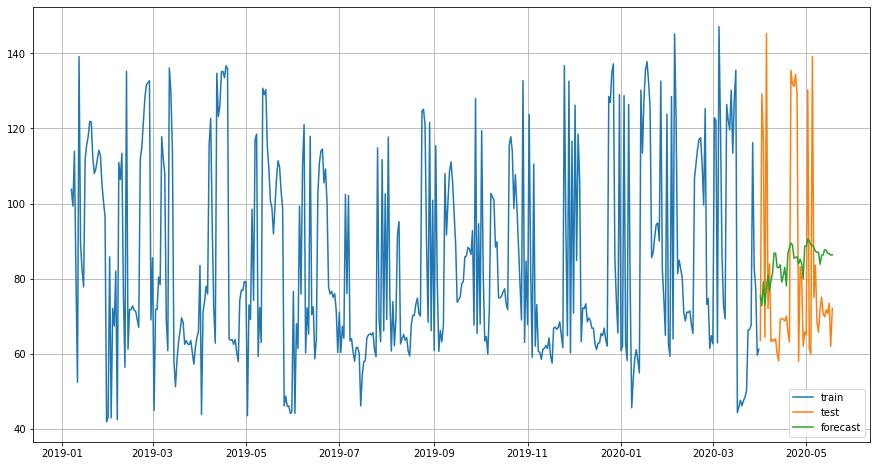

In [90]:
# visualizing the forecasted values:

plt.plot(train,label='train')
plt.plot(test,label='test')
plt.plot(forecast,label='forecast')
plt.grid()
plt.legend(loc='best')
plt.show()

In [91]:
print("MAE:",MAE(test['Usage'],forecast))
print("MAPE:",MAPE(test['Usage'],forecast))

MAE: 22.89369911972307
MAPE: 27.22650918929607
